## 2. The IntervalArithmetic.jl package

Now that we have covered some basic ideas of interval arithmetic, you should be able, in principle, to implement each operation. But guaranteeing that the results are rounded correctly, getting all the corner cases right, with generic code, all while achieving high performance, is non-trivial.

Together with Luis Benet (ICF-UNAM, Mexico) we have been developing the `IntervalArithmetic.jl` package since 2014. Within the next couple of months we expect it to be compliant with the IEEE-1788 Standard document, which specifies how interval arithmetic packages should behave. It passes a large, independently-developed test suite, ITF1788. 

In order to get to some of the interesting applications of these methods, we will now switch to using the `IntervalArithmetic.jl` package that we have been developing 

As usual, we install the package with

In [ ]:
] add IntervalArithmetic

and load it with

In [1]:
using IntervalArithmetic

This is a complete implementation of interval arithmetic that is very fast for `Float64` intervals, but also allows other floating-point types, in particular `BigFloat` (which are slow, because `BigFloat`s are slow).

The two main ways to create an interval are as follows:

In [2]:
X1 = interval(0.1, 0.3)  # note: lower-case `i`

[0.1, 0.3]

In [3]:
typeof(X1)

Interval{Float64}

In [4]:
interval(0.3, 0.1)

ArgumentError: ArgumentError: `[0.3, 0.1]` is not a valid interval. Need `a ≤ b` to construct `interval(a, b)`.

In [5]:
X2 = 0.1..0.3    # .. operator

[0.0999999, 0.300001]

Note that these give slightly different results: the `..` operator currently tries to be "clever" and guess "what you really meant": in this case you supposedly "really meant" the true real number 0.1, not the floating-point number `0.1`. However, we are strongly considering removing this perhaps-too-clever behaviour.

All the standard arithmetic and elementary functions have methods defined for intervals. For example:

In [6]:
X1 + X2

[0.199999, 0.600001]

This means that you can use standard Julia functions with intervals as follows:

In [7]:
f(x) = x^2 + 2x

f (generic function with 1 method)

In [8]:
X = -1..1

[-1, 1]

In [9]:
f(X)

[-2, 3]

By the fundamental theorem of interval arithmetic, this result is guaranteed to be an enclosure of the true range of the function over the set. However, in this case, even for such an apparently simple function, it turns out to be an *over*-approximation.

#### Exercise

1. Define functions `f1` and `f2` giving equivalent algebraic versions of the function (by factorising etc.). Do they give better or worse ranges? Can you find the exact range?

In [10]:
f1(x) = x * (x + 2)
f2(x) = (x + 1)^2 - 1

f1(X), f2(X)

([-3, 3], [-1, 3])

## Set operations

Since intervals are sets, it also makes sense to define standard set operations. Since this is Julia, we can *use the correct mathematical operators* for this!

In [11]:
(1..3) ∩ (2..4)  # \cap <TAB>

[2, 3]

In [12]:
∩

intersect (generic function with 27 methods)

In [14]:
@edit (1..3) ∩ (2..4) 

In [17]:
x = emptyinterval(Float64)

∅

In [18]:
x.lo

Inf

In [19]:
x.hi

-Inf

This makes the code so nice to read and understandable.

#### Exercise

How can you calculate the set difference of two intervals? What should it give you? What does it give you?

In [20]:
setdiff(1..5, 2..3)   

2-element Array{Interval{Float64},1}:
 [1, 2]
 [3, 5]

## Kahan's example

Let's go back to Kahan's example from the start of the last notebook.

In [21]:
f(x) = (1/80) * log(abs(3*(1 - x) + 1)) + x^2 + 1

f (generic function with 1 method)

Since all of these functions are defined for intervals, we can find an enclosure of the range of this function over a given input interval $X$ by just evaluating the function using that input interval:

In [22]:
f(1.0..1.2)

[1.98854, 2.44001]

In [23]:
f(1.0)

2.0

In [24]:
f(1.2)

2.428546365851573

Now let's try the key region:

In [25]:
f(1.3..1.4)

[-∞, 2.93989]

We see that interval arithmetic manages what we were previously unable to do: It warns us that something weird *might* be happening in this interval. But note that since this is only guaranteed to be an *over*-approximation, it does not guarantee that the range actually goes all the way to $-\infty$; that is something you can work out only by analytical means.

## Improving enclosures: Bounding functions

How can we improve an *over*-estimate of a range? It turns out that we can decrease the amount of over-estimation by simply splitting up the initial interval into pieces. This is sometimes called **mincing** the interval.

In [26]:
using Plots

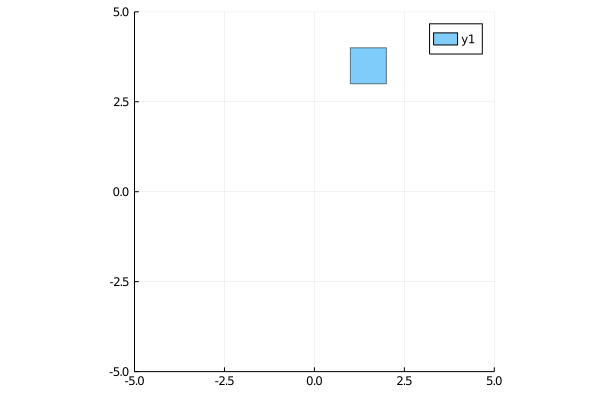

In [29]:
plot(IntervalBox(1..2, 3..4), ratio=1, xlim=(-5, 5), ylim=(-5, 5))

#### Exercise

1. Write a function `mymince` to split a given interval $X$ into $N$ equal-sized pieces.


2. For the function $f(x) = x^2 + 2x$ visualize the input and output intervals.


3. Make this into an interactive visualization with `Interact.jl` where you vary the number $N$ of sub-intervals.s


4. Apply this to the Kahan function. You will need to check for infinity and cut off the result at a finite value.

In [33]:
X = -3..3

[-3, 3]

In [36]:
f(x) = x^2 + 2x

f (generic function with 1 method)

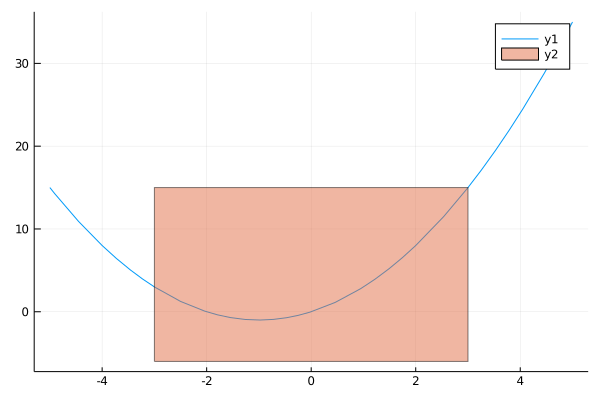

In [38]:
plot(f, -5, 5)
plot!(IntervalBox(X, f(X)))

In [40]:
Xs = mince(X, 10)

10-element Array{Interval{Float64},1}:
 [-3, -2.39999]
     [-2.4, -1.8]
     [-1.80001, -1.19999]
     [-1.2, -0.599999]
     [-0.6, 0]
   [0, 0.6]
      [0.599999, 1.2]
      [1.19999, 1.80001]
      [1.8, 2.4]
      [2.39999, 3]

In [41]:
f.(Xs)

10-element Array{Interval{Float64},1}:
   [-0.240001, 4.20001]
   [-1.56001, 2.16]
   [-2.16001, 0.840001]
   [-2.04001, 0.24]
   [-1.2, 0.36]
 [0, 1.56001]
    [1.55999, 3.84]
    [3.83999, 6.84001]
    [6.83999, 10.5601]
   [10.5599, 15]

In [44]:
using Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-14571528150671196363\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-10015748884404443987\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-14571528150671196363\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [47]:
 
@manipulate for N in 1:100
    Xs = mince(X, N)
    
    plot(f, -5, 5)
    plot!(IntervalBox.(Xs, f.(Xs)))
    
    ylims!(-10, 20)
end
    

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["N"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 100,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
50, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/dpsanders/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/dpsanders/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/dpsanders/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/Users/dpsanders/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/Users/dpsanders/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000010f51c6d0, Task (runnable) @0x000000010f51c6d0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\

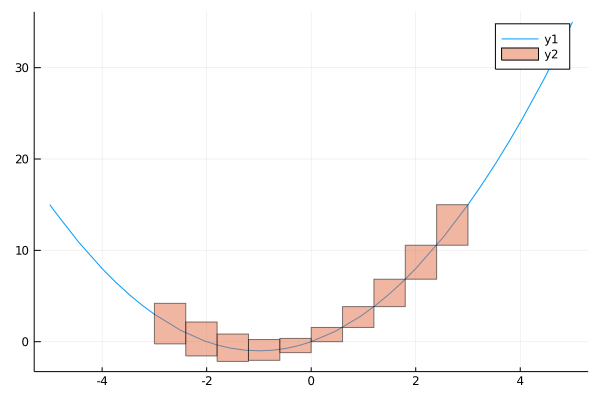

In [43]:
plot(f, -5, 5)
plot!(IntervalBox.(Xs, f.(Xs)))

In [48]:
kahan(x) = (1/80) * log(abs(3*(1 - x) + 1)) + x^2 + 1

kahan (generic function with 1 method)

In [49]:
kahan(1.3..1.4)

[-∞, 2.93989]

In [ ]:
 
@manipulate for N in 1:100
    Xs = mince(X, N)
    
    plot(f, -5, 5)
    outputs = f.(Xs)
    
    ylims!(-10, 20)
end
    

## Application: Numerical integration

A nice, simple application of interval arithmetic is to calculate integrals of functions numerically. For simplicity let's restrict ourselves to functions $f: \mathbb{R} \to \mathbb{R}$, although in principal the same idea extends to higher dimensions.

Recall that the integral
$$I := \int_a^b f(x) \, dx$$
represents the set $A$ between the function $f$ and the $x$-axis between $a$ and $b$.
    
We can approximate this by splitting up the interval $[a, b]$ into pieces and using a set of rectangles of the right height. Which is the right height? Standard numerical methods take e.g. $f(m)$, where $m$ is the midpoint.

Instead, having intervals at our disposal, we can *evaluate $f$ over the whole interval*! This will give us guaranteed lower and upper bounds for $f$ over that interval. Taking those lower and upper bounds gives two possible rectangles: one which is contained in $A$, and one which contains the part of $A$ that lies between $a$ and $b$.

In other words, interval arithmetic immediately gives us Riemann lower and upper sums, and hence rigorous bounds for $I$!

#### Exercise

1. Implement this. Apply it to different functions.


2. How fast does the approximation improve as you take more sub-intervals?

In [50]:
f(1..3)

[3, 15]

In [53]:
z = Complex(1..2, 3..4);

In [58]:
z * z;

In [55]:
z.re

[1, 2]

In [56]:
z.im

[3, 4]

In [60]:
function integrate(f, X, N)
    Xs = mince(X, N)
    
    return sum(diam.(Xs) .* f.(Xs))
end

integrate (generic function with 1 method)

In [62]:
integrate(x->x^2, 0..1, 10)

[0.284999, 0.385001]

In [63]:
integrate(x->x^2, 0..1, 100)

[0.328349, 0.338351]

In [64]:
integrate(x->x^2, 0..1, 10000)

[0.333283, 0.333384]

#### Exercise

## Formatting

The `@format` macro changes the way that intervals are displayed:

In [66]:
X = 0.1..0.3  # default is standard mode with 6 significant figures

[0.0999999, 0.300001]

In [67]:
@format midpoint 3

Display parameters:
- format: midpoint
- decorations: false
- significant figures: 3

In [68]:
X

0.2 ± 0.101

In [69]:
@format full

Display parameters:
- format: full
- decorations: false
- significant figures: 3

In [70]:
X

Interval(0.09999999999999999, 0.30000000000000004)

In [71]:
@format standard 10

Display parameters:
- format: standard
- decorations: false
- significant figures: 10

In [72]:
X

[0.09999999999, 0.3000000001]

In standard mode the displayed result is always an *enclosure* of the interval.
In `full` mode the floating-point endpoints are displayed using the usual Julia algorithm.

## In progress:

In [73]:
IntervalArithmetic.configure!(directed_rounding=:fast, powers=:fast)

UndefVarError: UndefVarError: configure! not defined